# CCFlex and Sun's and Google's code guidelines violations

We validate the accuracy of CCFlex when predicting lines violating Sun's and Google's coding conventions for Java using three codebases:
- Eclipse Platform
- Spring Framework
- Jasper Reports

We use Checkstyle as an oracle to automatically generate labels for each line (positive or 1 - line violates the rule(s); negative or 0 - line is correct)

We use features' files generated by CCFlex but instead of using its own module called 'classify' (which trains a classifier and applies it to a perviously unseen codebase), we perform the training of the classifier and validate its accuracy using 10 runs of 10-fold cross-validation.


## Imports and general-purpose variables and functions

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re
from collections import Counter
import csv

import itertools
import gc

import warnings

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.dummy import DummyClassifier

np.set_printoptions(precision=3)


from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_selection import SelectKBest, SelectPercentile, RFE, RFECV
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression

In [87]:
gc.collect()

0

In [3]:
seed = 123232424

from random import randint
seeds = [randint(0, 1000000)]*20

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=3)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Load the data generated by CCFlex

We load features from a csv file generated by CCFlex. In the tool, such files are used to train classifiers. 

The loaded file contains features for all three considered codebases.

In [80]:
all_code_features = pd.read_csv('data/ctx-train-features-low-var.csv.gz', compression='gzip', sep='$')

We need to unify the id column so the paths start from the 'src' (the same as in the files with code violations)

In [81]:
def shorten_input_path(x):
    return x.replace('all\\', '').replace("\\",'/')

all_code_features['id'] = all_code_features['id'].map(shorten_input_path)

In [82]:
all_code_features['id'].head(1).tolist()

['src/org/springframework/web/servlet/config/annotation/EnableWebMvc.java:1']

We filter the dataset to divide it to the datasets for each codebase.

In [86]:
jasper_code_features = all_code_features[all_code_features['id'].str.contains(re.escape("net/sf/jasperreports"))]

In [89]:
spring_code_features = all_code_features[all_code_features['id'].str.contains(re.escape("org/springframework"))]

In [90]:
eclipse_code_features = all_code_features[all_code_features['id'].str.contains(re.escape("org/eclipse"))]

Let's check if the number of lines in the original dataset and sum of lines in subsets is equal.

In [88]:
all_code_features.shape

(45365, 12409)

In [91]:
jasper_code_features.shape[0] + spring_code_features.shape[0] + eclipse_code_features.shape[0]

45365

## Load code violations

We load files generated using Checkstyle for the same codebases.

Some of the messages contain references to particular classes, methods, etc. We need to unify them so we know they represent the same type of violation.

In [131]:
sun_violations = pd.read_csv('data/all-sun.csv.gz', compression='gzip', sep=',')

In [132]:
SUN_MESSAGES = (
    "Class designed for extension without Javadoc",
    "Parameter should be final",
    "Variable must be private and have accessor methods",
    "Unused import",
    "Unused @param tag",
    "Unable to get class information for @throws tag",
    "Name must match pattern '^[A-Z][A-Z0-9]*(_[A-Z0-9]+)*$'",
    "Method length greater than 150",
    "Line is longer than 80 characters",
    "Unknown tag",
    "Unclosed HTML tag found",
    "Extra HTML tag found",
    "Expected @throws tag",
    "Expected @param tag",
    "Class should be declared as final",
    "Magic number",
    "Hidden field",
    "Symbol is not followed by whitespace.",
    "Symbol should be on a new line.",
    "Symbol is not preceded with whitespace.",
    "Symbol is followed by whitespace.",
    "Symbol is preceded with whitespace.",
    "'{' should be on the previous line.",
    "'}' should be on the same line as the next part of a multi-block statement",
)

SUN_ORIGINAL_PATTERNS = (
    "Class '.+'.*",
     "Parameter [a-zA-Z0-9]+ should be final.",
     "Variable '[a-zA-Z0-9_]+' must be private and have accessor methods.",
     "Unused import - .*",
     "Unused @param tag for.*",
     "Unable to get class information for @throws tag '.*",
     "Name '.+' must match pattern.",
     "Method length is .*",
     "Line is longer than 80 characters.*",
     "Unknown tag.*",
     "Unclosed HTML tag found.*",
     "Extra HTML tag found.*",
     "Expected @throws tag for.*",
     "Expected @param tag for.*",
     "Class .+ should be declared as final",
     ".+ is a magic number.",
     ".+hides a field.",
     ".+ is not followed by whitespace.*",
     ".+ should be on a new line.*",
     ".+ is not preceded with whitespace.*",
     ".+ is followed by whitespace.*",
     ".+ is preceded with whitespace.*",
     "'[{]' at column .+ should be on the previous line.",
     "'[}]' at column .+ should be on the same line as.+",
)

SUN_ORIGINAL_PATTERNS_COMPILED = [re.compile(x) for x in SUN_ORIGINAL_PATTERNS]

def replace_sun_violation(message):
    for i, pattern in enumerate(SUN_ORIGINAL_PATTERNS_COMPILED):
        if pattern.match(message):
            return SUN_MESSAGES[i]
    return message
    

In [133]:
sun_violations['message'] = sun_violations['message'].map(replace_sun_violation)

In [134]:
def shorten_sun_path(x):
    return x.replace('/Users/mochodek/Documents/Badania/Chalmers ML/Lines of code/Code Style/codebase/all-sun/', '')

sun_violations['resource'] = sun_violations['resource'].map(shorten_sun_path)

In [135]:
sun_violations['resource'].head(1).tolist()

['src/net/sf/jasperreports/engine/base/BaseCommonReturnValue.java']

In [136]:
sun_violations['id'] = sun_violations.apply(lambda row : f'{row.resource}:{row.line}', axis=1)

In [137]:
SUN_RULES = sun_violations['message'].unique()

In [138]:
SUN_RULES

array(['Line is longer than 80 characters', 'Line has trailing spaces.',
       "'{' should be on the previous line.",
       'File contains tab characters (this is the first instance).',
       'Variable must be private and have accessor methods',
       'Missing a Javadoc comment.', 'Parameter should be final',
       'Class designed for extension without Javadoc',
       "'}' should be on the same line as the next part of a multi-block statement",
       'Hidden field', 'Symbol is not followed by whitespace.',
       "Name must match pattern '^[A-Z][A-Z0-9]*(_[A-Z0-9]+)*$'",
       'Expected @param tag', 'Avoid inline conditionals.',
       'Symbol is followed by whitespace.',
       'Symbol is preceded with whitespace.',
       'switch without "default" clause.',
       'Symbol is not preceded with whitespace.', 'Unused import',
       'Expected an @return tag.', 'Avoid nested blocks.', 'Magic number',
       'Symbol should be on a new line.',
       'File does not end with a newli

In [139]:
google_violations = pd.read_csv('data/all-google.csv.gz', compression='gzip', sep=',')

In [140]:
GOOGLE_MESSAGES = (
    "Incorrect indentation level",
    "Wrong lexicographical order for import",
    "Whitespace around a symbol is not followed by whitespace",
    "Whitespace around a symbol is not preceded by whitespace",
    "Parameter must match pattern '^[a-z]([a-z0-9][a-zA-Z0-9]*)?$'",
    "Overload methods should not be split",
    "Member name must match pattern '^[a-z][a-z0-9][a-zA-Z0-9]*$'",
    "Local variable name must match pattern '^[a-z]([a-z0-9][a-zA-Z0-9]*)?$'",
    "Line is longer than 100 characters",
    "Javadoc comment has parse error.",
    "Distance between variable declaration and its first usage is more than '3'",
    "Abbreviation in name must contain no more than '2' consecutive capital letters",
    "'}' should be on the same line as the next part of a multi-block statement",
    "'{' should be on the previous line",
    "Symbol should be on a new line",
)

GOOGLE_ORIGINAL_PATTERNS = (
    ".+incorrect indentation level.*",
    "Wrong lexicographical order for.*",
    "WhitespaceAround:.* is not followed by whitespace.*",
    "WhitespaceAround:.* is not preceded with whitespace.*",
    "Parameter name .+ must match pattern.*",
    "Overload methods should not be split.*",
    "Member name .* must match pattern.*",
    "Local variable name .+ must match pattern.*",
    "Line is longer than 100 characters.*",
    "Javadoc comment at column .+ has parse error.*",
    "Distance between variable.*",
    "Abbreviation in name.*",
    "'[}]' at column .+ should be on the same line as the next part of a multi-block statement.*",
    "'[{]' at column .+ should be on the previous line.*",
    ".+ should be on a new line.*",
)

GOOGLE_ORIGINAL_PATTERNS_COMPILED = [re.compile(x) for x in GOOGLE_ORIGINAL_PATTERNS]

def replace_google_violation(message):
    for i, pattern in enumerate(GOOGLE_ORIGINAL_PATTERNS_COMPILED):
        if pattern.match(message):
            return GOOGLE_MESSAGES[i]
    return message
    

In [141]:
google_violations['message'] = google_violations['message'].map(replace_google_violation)

In [142]:
GOOGLE_RULES = google_violations['message'].unique()

In [143]:
GOOGLE_RULES

array(["'package' should be separated from previous statement.",
       "'{' should be on the previous line",
       'First sentence of Javadoc is incomplete (period is missing) or not present.',
       'Line contains a tab character.', 'Incorrect indentation level',
       '<p> tag should be placed immediately before the first word, with no space after.',
       '<p> tag should be preceded with an empty line.',
       "'}' should be on the same line as the next part of a multi-block statement",
       'Wrong lexicographical order for import',
       'Line is longer than 100 characters', 'Missing a Javadoc comment.',
       "Abbreviation in name must contain no more than '2' consecutive capital letters",
       "Member name must match pattern '^[a-z][a-z0-9][a-zA-Z0-9]*$'",
       'At-clause should have a non-empty description.',
       'Whitespace around a symbol is not followed by whitespace',
       "'(' is followed by whitespace.",
       "')' is preceded with whitespace.",
       

In [144]:
def shorten_google_path(x):
    return x.replace('/Users/mochodek/Documents/Badania/Chalmers ML/Lines of code/Code Style/codebase/all-google/', '')

google_violations['resource'] = google_violations['resource'].map(shorten_google_path)

In [145]:
google_violations['resource'].head(1).tolist()

['src/net/sf/jasperreports/engine/base/BaseCommonReturnValue.java']

In [146]:
google_violations['id'] = google_violations.apply(lambda row : f'{row.resource}:{row.line}', axis=1)

In [147]:
google_violations['id'].head(1).tolist()

['src/net/sf/jasperreports/engine/base/BaseCommonReturnValue.java:24']

## Experiment - validating the accuracy of CCFlex

We peform 10 runs of 10-fold cross-validation using the features generated by CCFlex. We mimic the behavior of one of the CCFlex modules called 'clssify'.

### Validate accuracy for a single rule

In [66]:
warnings.simplefilter('ignore')

def validate_rule(model, features, violations, rule = None, subset = 1, runs = 10):
    '''Performs n runs of 10-fold cross-validation for a given rule (if rule is None than
       all rules are taken into account and line has to violate either of them to be classified
       to a positive class (1).'''

    # filter only the violations of the rule
    if rule is not None:
        rule_violations = violations[violations['message'] == rule]
        rulename = rule
    else:
        rule_violations = violations
        rulename = 'Any'
    print(f'### Validate rule: {rulename}...')
     
    # Determine the class column
    lines_violating_rules = set(rule_violations['id'].tolist())
    features['class_value'] = features.apply(lambda x: 1 if x.id in lines_violating_rules else 0, axis=1)
    
    X = features.drop(['id', 'contents', 'class_name', 'class_value'], axis = 1, inplace = False, errors = 'ignore')
    y = features['class_value']
    
    if subset < 1:
        print(f'Selecting {subset*100}% of lines out of {X.shape[0]}...')
        skfold = StratifiedKFold(n_splits=int(1/subset), shuffle=True, random_state=seeds[0])
        _, ids = next(skfold.split(X, y))
        X, y = X.iloc[ids, :], y.iloc[ids]

    counter_y = Counter(y)
    results = dict(acc=[], rec=[], prec=[],fscore=[], cnf=[],
                  subset=subset, n=X.shape[0], 
                  n_pos=counter_y[1], n_neg=counter_y[0])
    
    print(f"Lines = {results['n']}; positive = {results['n_pos']}; negative = {results['n_neg']}")

    for run in range(runs):
        skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seeds[run])
        kfold = KFold(n_splits=10, shuffle=True, random_state=seeds[run])
        print(f'Run {run+1} / {runs}')
        cv_preds = []
        cv_trues = []
        print('- Fold: ', end=" ")
        fold = 1
        for train_index, val_index in skfold.split(X, y):
        #for train_index, val_index in kfold.split(X): # use to random sampling instead of stratified random
            print(f'{fold}', end=' ')
            model.fit(X.iloc[train_index,:], y.iloc[train_index])
            class_weights = class_weight.compute_class_weight('balanced', np.unique(y.iloc[train_index]), y.iloc[train_index])
            cv_preds += model.predict(X.iloc[val_index,:]).tolist()
            cv_trues += y.iloc[val_index].tolist()
            fold += 1
        print("")
        results['acc'].append(accuracy_score(cv_trues, cv_preds))
        results['rec'].append(recall_score(cv_trues, cv_preds))
        results['prec'].append(precision_score(cv_trues, cv_preds))
        results['fscore'].append(f1_score(cv_trues, cv_preds))
        results['cnf'].append(confusion_matrix(cv_trues, cv_preds))
   
    return results

Let's test it:

In [51]:
res = validate_rule(model = DecisionTreeClassifier(class_weight = 'balanced'), 
              features = jasper_code_features,
              violations = google_violations, 
              rule = GOOGLE_RULES[1], 
              subset = 1,
              runs = 10)

### Validate rule: '{' should be on the previous line...
Lines = 14875; positive = 1479; negative = 13396
- Run 1 / 10
Fold:  1 2 3 4 5 6 7 8 9 10 
- Run 2 / 10
Fold:  1 2 3 4 5 6 7 8 9 10 
- Run 3 / 10
Fold:  1 2 3 4 5 6 7 8 9 10 
- Run 4 / 10
Fold:  1 2 3 4 5 6 7 8 9 10 
- Run 5 / 10
Fold:  1 2 3 4 5 6 7 8 9 10 
- Run 6 / 10
Fold:  1 2 3 4 5 6 7 8 9 10 
- Run 7 / 10
Fold:  1 2 3 4 5 6 7 8 9 10 
- Run 8 / 10
Fold:  1 2 3 4 5 6 7 8 9 10 
- Run 9 / 10
Fold:  1 2 3 4 5 6 7 8 9 10 
- Run 10 / 10
Fold:  1 2 3 4 5 6 7 8 9 10 


In [56]:
res

{'acc': [0.9997983193277311,
  0.9997983193277311,
  0.9998655462184874,
  0.9997983193277311,
  0.9998655462184874,
  0.9997983193277311,
  0.9997983193277311,
  0.9998655462184874,
  0.9998655462184874,
  0.9997983193277311],
 'rec': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'prec': [0.9979757085020243,
  0.9979757085020243,
  0.9986495611073599,
  0.9979757085020243,
  0.9986495611073599,
  0.9979757085020243,
  0.9979757085020243,
  0.9986495611073599,
  0.9986495611073599,
  0.9979757085020243],
 'fscore': [0.9989868287740628,
  0.9989868287740628,
  0.9993243243243243,
  0.9989868287740628,
  0.9993243243243243,
  0.9989868287740628,
  0.9989868287740628,
  0.9993243243243243,
  0.9993243243243243,
  0.9989868287740628],
 'cnf': [array([[13393,     3],
         [    0,  1479]], dtype=int64), array([[13393,     3],
         [    0,  1479]], dtype=int64), array([[13394,     2],
         [    0,  1479]], dtype=int64), array([[13393,     3],
         [    0,  1479]], dtype

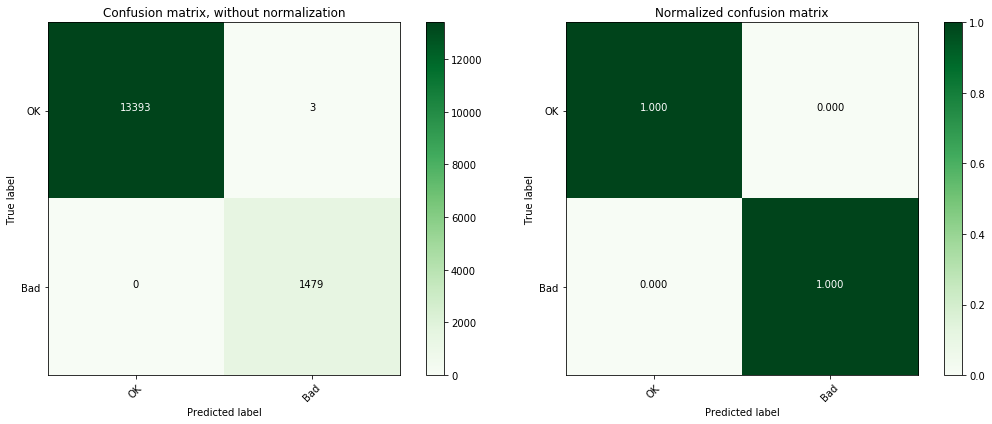

In [55]:
classes_names={0:'OK', 1:'Bad'}
cnf_matrix = res['cnf'][0]
plt.figure(figsize=(15,6))


plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix, classes=list(classes_names.values()),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix, classes=list(classes_names.values()), normalize=True,
                      title='Normalized confusion matrix')
plt.show()
plt.close()

### Validate for a set of rules

In [77]:
warnings.simplefilter('ignore')

def validate_rules(model, features, violations, rules = [],  
                   subsets = [], runs = 10, 
                   filename = 'results.csv'):
    '''Performs a validation experiment on a given codebase and set of rules'''
    
    print('Starting validation...')
    
    with open(filename, 'w', newline='') as f: 
        writer = csv.DictWriter(f, delimiter=';',
                                fieldnames=['rule', 'n', 'n_pos', 'n_neg', 'subset',
                                            'acc', 'acc_std', 'rec', 'rec_std', 
                                            'prec', 'prec_std', 'fscore', 'fscore_std'])
        writer.writeheader()
        f.flush()
        for subset in subsets:
            print(f'Performing validation for the subset {subset}...')
            res = validate_rule(model = model, 
                                  features = features,
                                  violations = violations, 
                                  rule = None, 
                                  subset = subset,
                                  runs = runs)
            writer.writerow(dict(rule='Any', n=res['n'], n_pos=res['n_pos'], n_neg=res['n_neg'], subset=res['subset'],
                                acc=np.mean(res['acc']), acc_std=np.std(res['acc']),
                                rec=np.mean(res['rec']), rec_std=np.std(res['rec']),
                                prec=np.mean(res['prec']), prec_std=np.std(res['prec']),
                                fscore=np.mean(res['fscore']), fscore_std=np.std(res['fscore'])))
            f.flush()
            for rule in rules:
                res = validate_rule(model = model, 
                                  features = features,
                                  violations = violations, 
                                  rule = rule, 
                                  subset = subset,
                                  runs = runs)
                writer.writerow(dict(rule=rule, n=res['n'], n_pos=res['n_pos'], n_neg=res['n_neg'], subset=res['subset'],
                                    acc=np.mean(res['acc']), acc_std=np.std(res['acc']),
                                    rec=np.mean(res['rec']), rec_std=np.std(res['rec']),
                                    prec=np.mean(res['prec']), prec_std=np.std(res['prec']),
                                    fscore=np.mean(res['fscore']), fscore_std=np.std(res['fscore'])))
                f.flush()
                
    
    

### All projects

In [ ]:
validate_rules(model = DecisionTreeClassifier(class_weight = 'balanced'), 
              features = all_code_features,
              violations = google_violations, 
              rules = GOOGLE_RULES, 
              subsets = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
              runs = 10,
              filename = 'google-all-results.csv')

Starting validation...
Performing validation for the subset 0.05...
### Validate rule: Any...
Selecting 5.0% of lines...
Lines = 2269; positive = 1535; negative = 734
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'package' should be separated from previous statement....
Selecting 5.0% of lines...
Lines = 2269; positive = 5; negative = 2264
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
-

Lines = 2269; positive = 1; negative = 2268
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'protected' modifier out of order with the JLS suggestions....
Selecting 5.0% of lines...
Lines = 2269; positive = 0; negative = 2269
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 

- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: At-clause should have a non-empty description....
Selecting 10.0% of lines...
Lines = 4537; positive = 32; negative = 4505
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Whitespace around a symbol is not followed by whitespace...
Selecting 10.0% of lines...
Lines = 4538; positive = 8; negative = 4530
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant <p> tag....
Selecting 10.0% of lines...
Lines = 4538; positive = 1; negative = 4537
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Performing validation for the subset 0.2...
### Validate rule: Any...
Selecting 20.0% of lines...
Lines = 9074; positive = 6139; negative = 2935
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9

- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'else' construct must use '{}'s....
Selecting 20.0% of lines...
Lines = 9073; positive = 0; negative = 9073
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must use '{}'s....
Selecting 20.0% of lines...
Lines = 9073; positive = 3; negative = 9070
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
R

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant <p> tag....
Selecting 20.0% of lines...
Lines = 9073; positive = 0; negative = 9073
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Performing validation for the subset 0.3...
### Validate

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'else' construct must use '{}'s....
Selecting 30.0% of lines...
Lines = 15122; positive = 1; negative = 15121
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'METHOD_DEF' should be separated from previous statement....
Selecting 30.0% of lines...
Lines = 15123; positive = 2; negative = 15121
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant <p> tag....
Selecting 30.0% of lines...
Lines = 15123; positive = 1; negative = 15122
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 

Selecting 40.0% of lines...
Lines = 22683; positive = 34; negative = 22649
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Member name must match pattern '^[a-z][a-z0-9][a-zA-Z0-9]*$'...
Selecting 40.0% of lines...
Lines = 22683; positive = 17; negative = 22666
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10

- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Single-line Javadoc comment should be multi-line....
Selecting 40.0% of lines...
Lines = 22683; positive = 2; negative = 22681
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'METHOD_DEF' should be separated from previous statement....
Selecting 40.0% of lines...
Lines = 22683; positive = 2; negative = 22681
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'if' construct must use '{}'s....
Selecting 50.0% of lines...
Lines = 22683; positive = 46; negative = 22637
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'CTOR_DEF' should be separated from previous statement....
Selecting 50.0% of lines...
Lines = 22683; positive = 1; negative = 22682
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fo

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Single-line Javadoc comment should be multi-line....
Selecting 50.0% of lines...
Lines = 22683; positive = 2; negative = 22681
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'MET

In [72]:
validate_rules(model = DecisionTreeClassifier(class_weight = 'balanced'), 
              features = all_code_features,
              violations = sun_violations, 
              rules = SUN_RULES, 
              subsets = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
              runs = 10,
              filename = 'sun-all-results.csv')

Starting validation...
Performing validation for the subset 0.05...
### Validate rule: Any...
Selecting 5.0% of lines...
Lines = 745; positive = 528; negative = 217
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Line is longer than 80 characters...
Selecting 5.0% of lines...
Lines = 744; positive = 0; negative = 744
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'if' construct must use '{}'s....
Selecting 5.0% of lines...
Lines = 744; positive = 0; negative = 744
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Utility classes should not have a public or default constructor....
Selecting 5.0% of lines...
Lines = 744; positive = 0; negative = 744
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Name must match pattern '^[A-Z][A-Z0-9]*(_[A-Z0-9]+)*$'...
Selecting 10.0% of lines...
Lines = 1488; positive = 0; negative = 1488
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Expected @param tag...
Selecting 10.0% of lines...
Lines = 1488; positive = 0; negative = 1488
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'static' modifier out of order with the JLS suggestions....
Selecting 10.0% of lines...
Lines = 1489; positive = 1; negative = 1488
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: First sentence should end with a period....
Selecting 10.0% of lines...
Lines = 1488; positive = 0; negative = 1488
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 1

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Expression can be simplified....
Selecting 10.0% of lines...
Lines = 1488; positive = 0; negative = 1488
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Extra HTML tag found...
Selecting 10.0% of lines...
Lines = 1488; positive = 0; negative = 1488
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- F

KeyboardInterrupt: 

### Jasper Reports

In [148]:
validate_rules(model = DecisionTreeClassifier(class_weight = 'balanced'), 
              features = jasper_code_features,
              violations = google_violations, 
              rules = GOOGLE_RULES, 
              subsets = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
              runs = 10,
              filename = 'google-jasper-results.csv')

Starting validation...
Performing validation for the subset 0.05...
### Validate rule: Any...
Selecting 5.0% of lines...
Lines = 745; positive = 528; negative = 217
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'package' should be separated from previous statement....
Selecting 5.0% of lines...
Lines = 745; positive = 4; negative = 741
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fol

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Whitespace around a symbol is not followed by whitespace...
Selecting 5.0% of lines...
Lines = 744; positive = 2; negative = 742
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: '(' is followed by whitespace....
Selecting 5.0% of lines...
Lines = 745; positive = 2; negative = 743
Run 1 / 10
- Fold:  1 2 3

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'protected' modifier out of order with the JLS suggestions....
Selecting 5.0% of lines...
Lines = 744; positive = 0; negative = 744
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule:

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Performing validation for the subset 0.1...
### Validate rule: Any...
Selecting 10.0% of lines...
Lines = 1488; positive = 1055; negative = 433
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'package' should be separated from previous statement....
Selecting 10.0% of lines...
Lines = 1488; positive = 7; negative = 1481
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Ru

Selecting 10.0% of lines...
Lines = 1489; positive = 5; negative = 1484
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Whitespace around a symbol is not followed by whitespace...
Selecting 10.0% of lines...
Lines = 1488; positive = 4; negative = 1484
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must use '{}'s....
Selecting 10.0% of lines...
Lines = 1488; positive = 0; negative = 1488
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'protected' modifier out of order with the JLS suggestions....
Selecting 10.0% of lines...
Lines = 1488; positive = 0; negative = 1488
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fo

Lines = 1488; positive = 0; negative = 1488
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Performing validation for the subset 0.2...
### Validate rule: Any...
Selecting 20.0% of lines...
Lines = 2976; positive = 2110; negative = 866
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
-

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: At-clause should have a non-empty description....
Selecting 20.0% of lines...
Lines = 2976; positive = 9; negative = 2967
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Whitespace around a symbol is not followed by whitespace...
Selecting 20.0% of lines...
Lines = 2975; positive = 7; negative = 2968
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must use '{}'s....
Selecting 20.0% of lines...
Lines = 2975; positive = 0; negative = 2975
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'protected' modifier out

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant <p> tag....
Selecting 20.0% of lines...
Lines = 2975; positive = 0; negative = 2975
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Performing validation for the subset 0.3...
### Validate rule: Any...
Selecting 30.0% of lines...
Lines = 4959; positive = 3516; negative = 1443
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9

Selecting 30.0% of lines...
Lines = 4959; positive = 7; negative = 4952
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: At-clause should have a non-empty description....
Selecting 30.0% of lines...
Lines = 4959; positive = 15; negative = 4944
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'else' construct must use '{}'s....
Selecting 30.0% of lines...
Lines = 4959; positive = 0; negative = 4959
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must use '{}'s....
Selecting 30.0% of lines...
Lines = 4959; positive = 0; negative = 4959
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 


Selecting 30.0% of lines...
Lines = 4959; positive = 0; negative = 4959
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant <p> tag....
Selecting 30.0% of lines...
Lines = 4959; positive = 0; negative = 4959
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fo

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Member name must match pattern '^[a-z][a-z0-9][a-zA-Z0-9]*$'...
Selecting 40.0% of lines...
Lines = 7438; positive = 10; negative = 7428
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: At-clause should have a non-empty description....
Selecting 40.0% of lines...
Lines = 7438; positive = 22; negative = 7416
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 1

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'else' construct must use '{}'s....
Selecting 40.0% of lines...
Lines = 7438; positive = 0; negative = 7438
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must us

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'METHOD_DEF' should be separated from previous statement....
Selecting 40.0% of lines...
Lines = 7438; positive = 0; negative = 7438
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant <p> tag....
Selecting 40.0% of lines...
Lines = 7438; positive = 0; negative = 7438
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 

Selecting 50.0% of lines...
Lines = 7438; positive = 32; negative = 7406
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Member name must match pattern '^[a-z][a-z0-9][a-zA-Z0-9]*$'...
Selecting 50.0% of lines...
Lines = 7438; positive = 10; negative = 7428
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- F

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'CTOR_DEF' should be separated from previous statement....
Selecting 50.0% of lines...
Lines = 7438; positive = 0; negative = 7438
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'else' construct must use '{}'s....
Selecting 50.0% of lines...
Lines = 7438; positive = 0; negative = 7438
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:

Selecting 50.0% of lines...
Lines = 7438; positive = 0; negative = 7438
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'METHOD_DEF' should be separated from previous statement....
Selecting 50.0% of lines...
Lines = 7438; positive = 0; negative = 7438
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold: 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Member name must match pattern '^[a-z][a-z0-9][a-zA-Z0-9]*$'...
Lines = 14875; positive = 20; negative = 14855
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: At-clause should hav

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'else' construct must use '{}'s....
Lines = 14875; positive = 0; negative = 14875
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must use '{}'s....
Lines = 14875; positive = 0; negative = 14875
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant <p> tag....
Lines = 14875; positive = 0; negative = 14875
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 


In [149]:
validate_rules(model = DecisionTreeClassifier(class_weight = 'balanced'), 
              features = jasper_code_features,
              violations = sun_violations, 
              rules = SUN_RULES, 
              subsets = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
              runs = 10,
              filename = 'sun-jasper-results.csv')

Starting validation...
Performing validation for the subset 0.05...
### Validate rule: Any...
Selecting 5.0% of lines...
Lines = 745; positive = 253; negative = 492
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Line is longer than 80 characters...
Selecting 5.0% of lines...
Lines = 744; positive = 51; negative = 693
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Symbol is followed by whitespace....
Selecting 5.0% of lines...
Lines = 745; positive = 2; negative = 743
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Symbol is preceded with whitespace....
Selecting 5.0% of lines...
Lines = 745; positive = 2; negative = 743
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
R

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'if' construct must use '{}'s....
Selecting 5.0% of lines...
Lines = 744; positive = 0; negative = 744
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Utility classes should not have a public or default constructor....
Selecting 5.0% of lines...
Lines = 744; positive = 0; negative = 744
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Array brackets at illegal position....
Selecting 5.0% of lines...
Lines = 744; positive = 0; negative = 744
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Unused @param tag...
Selecting 5.0% of lines...
Lines = 744; positive = 0; negative = 744
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Name must match pattern '^[A-Z][A-Z0-9]*(_[A-Z0-9]+)*$'...
Selecting 10.0% of lines...
Lines = 1489; positive = 3; negative = 1486
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Expected @param tag...
Selecting 10.0% of lines...
Lines = 1488; positive = 12; negative = 1476
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'static' modifier out of order with the JLS suggestions....
Selecting 10.0% of lines...
Lines = 1489; positive = 1; negative = 1488
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: First sentence should end with a period....
Selecting 10.0% of lines...
Lines = 1489; positive = 1; negative = 1488
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 1

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Expression can be simplified....
Selecting 10.0% of lines...
Lines = 1488; positive = 0; negative = 1488
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Extra HTML tag found...
Selecting 10.0% of lines...
Lines = 1488; positive = 0; negative = 1488
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- F

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: '}' should be on the same line as the next part of a multi-block statement...
Selecting 20.0% of lines...
Lines = 2976; positive = 11; negative = 2965
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: File does not end with a newline....
Selecting 20.0% of lines...
Lines = 2975; positive = 0; negative = 2975
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant 'public' mod

Lines = 2975; positive = 0; negative = 2975
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Unclosed HTML tag found...
Selecting 20.0% of lines...
Lines = 2975; positive = 0; negative = 2975
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 

Selecting 30.0% of lines...
Lines = 4959; positive = 79; negative = 4880
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Missing a Javadoc comment....
Selecting 30.0% of lines...
Lines = 4959; positive = 165; negative = 4794
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 1

- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Expected an @return tag....
Selecting 30.0% of lines...
Lines = 4959; positive = 25; negative = 4934
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Avoid nested blocks....
Selecting 30.0% of lines...
Lines = 4959; positive = 3; negative = 4956
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold: 

- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must use '{}'s....
Selecting 30.0% of lines...
Lines = 4959; positive = 0; negative = 4959
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'protected' modifier out of order with the JLS suggestions....
Selecting 30.0% of lines...
Lines = 4959; positive = 0; negative = 4959
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fol

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Line has trailing spaces....
Selecting 40.0% of lines...
Lines = 7438; positive = 475; negative = 6963
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: '{' should be on the previous line....
Selecting 40.0% of lines...
Lines = 7438; positive = 740; negative = 6698
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: switch without "default" clause....
Selecting 40.0% of lines...
Lines = 7438; positive = 1; negative = 7437
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Symbol is not preceded with whitespace....
Selecting 40.0% of lines...
Lines = 7438; positive = 7; negative = 7431
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Unknown tag...
Selecting 40.0% of lines...
Lines = 7438; positive = 0; negative = 7438
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Class should be declared as final...
Selecting 40.0% of lines...
Lines = 7438; positive = 0; negative = 7438
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold: 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Unable to get class information for @throws tag...
Selecting 40.0% of lines...
Lines = 7438; positive = 0; negative = 7438
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Performing validation for the subset 0.5...
### Validate rule: Any...
Selecting 50.0% of lines...
Lines = 7438;

Lines = 7438; positive = 60; negative = 7378
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Avoid inline conditionals....
Selecting 50.0% of lines...
Lines = 7438; positive = 13; negative = 7425
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant 'private' modifier....
Selecting 50.0% of lines...
Lines = 7438; positive = 1; negative = 7437
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'if' construct must use '{

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'public' modifier out of order with the JLS suggestions....
Selecting 50.0% of lines...
Lines = 7438; positive = 0; negative = 7438
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule:

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Symbol is not followed by whitespace....
Lines = 14875; positive = 198; negative = 14677
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Name must match pattern '^[A-Z][A-Z0-9]*(_[A-Z0-9]+)*$'...
Lines = 14875; positive = 21; negative = 14854
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'static' modifier out of order with the JLS suggestions....
Lines = 14875; positive = 2; negative = 14873
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: First sentence should end

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Expression can be simplified....
Lines = 14875; positive = 0; negative = 14875
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Extra HTML tag found...
Lines = 14875; positive = 0; negative = 14875
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 

### Spring Framework

In [150]:
validate_rules(model = DecisionTreeClassifier(class_weight = 'balanced'), 
              features = spring_code_features,
              violations = google_violations, 
              rules = GOOGLE_RULES, 
              subsets = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
              runs = 10,
              filename = 'google-spring-results.csv')

Starting validation...
Performing validation for the subset 0.05...
### Validate rule: Any...
Selecting 5.0% of lines...
Lines = 746; positive = 450; negative = 296
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'package' should be separated from previous statement....
Selecting 5.0% of lines...
Lines = 746; positive = 0; negative = 746
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fol

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Whitespace around a symbol is not followed by whitespace...
Selecting 5.0% of lines...
Lines = 746; positive = 0; negative = 746
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: '(' is followed by whitespace....
Selecting 5.0% of lines...
Lines = 746; positive = 0; negative = 746
Run 1 / 10
- Fold:  1 2 3

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'protected' modifier out of order with the JLS suggestions....
Selecting 5.0% of lines...
Lines = 746; positive = 0; negative = 746
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule:

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Performing validation for the subset 0.1...
### Validate rule: Any...
Selecting 10.0% of lines...
Lines = 1491; positive = 899; negative = 592
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'package' should be separated from previous statement....
Selecting 10.0% of lines...
Lines = 1492; positive = 1; negative = 1491
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run

Selecting 10.0% of lines...
Lines = 1492; positive = 1; negative = 1491
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Whitespace around a symbol is not followed by whitespace...
Selecting 10.0% of lines...
Lines = 1491; positive = 0; negative = 1491
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must use '{}'s....
Selecting 10.0% of lines...
Lines = 1491; positive = 0; negative = 1491
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'protected' modifier out of order with the JLS suggestions....
Selecting 10.0% of lines...
Lines = 1491; positive = 0; negative = 1491
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fo

Lines = 1492; positive = 1; negative = 1491
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Performing validation for the subset 0.2...
### Validate rule: Any...
Selecting 20.0% of lines...
Lines = 2981; positive = 1798; negative = 1183
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10


- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: At-clause should have a non-empty description....
Selecting 20.0% of lines...
Lines = 2981; positive = 0; negative = 2981
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Whitespace around a symbol is not followed by whitespace...
Selecting 20.0% of lines...
Lines = 2981; positive = 0; negative = 2981
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must use '{}'s....
Selecting 20.0% of lines...
Lines = 2981; positive = 0; negative = 2981
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'protected' modifier out

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant <p> tag....
Selecting 20.0% of lines...
Lines = 2981; positive = 0; negative = 2981
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Performing validation for the subset 0.3...
### Validate rule: Any...
Selecting 30.0% of lines...
Lines = 4968; positive = 2997; negative = 1971
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9

Selecting 30.0% of lines...
Lines = 4968; positive = 0; negative = 4968
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: At-clause should have a non-empty description....
Selecting 30.0% of lines...
Lines = 4968; positive = 1; negative = 4967
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'else' construct must use '{}'s....
Selecting 30.0% of lines...
Lines = 4968; positive = 0; negative = 4968
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must use '{}'s....
Selecting 30.0% of lines...
Lines = 4968; positive = 0; negative = 4968
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 


Selecting 30.0% of lines...
Lines = 4968; positive = 2; negative = 4966
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant <p> tag....
Selecting 30.0% of lines...
Lines = 4968; positive = 1; negative = 4967
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fo

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Member name must match pattern '^[a-z][a-z0-9][a-zA-Z0-9]*$'...
Selecting 40.0% of lines...
Lines = 7451; positive = 0; negative = 7451
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: At-clause should have a non-empty description....
Selecting 40.0% of lines...
Lines = 7452; positive = 1; negative = 7451
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'else' construct must use '{}'s....
Selecting 40.0% of lines...
Lines = 7451; positive = 0; negative = 7451
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must us

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'METHOD_DEF' should be separated from previous statement....
Selecting 40.0% of lines...
Lines = 7451; positive = 2; negative = 7449
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant <p> tag....
Selecting 40.0% of lines...
Lines = 7452; positive = 1; negative = 7451
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 

Selecting 50.0% of lines...
Lines = 7451; positive = 0; negative = 7451
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Member name must match pattern '^[a-z][a-z0-9][a-zA-Z0-9]*$'...
Selecting 50.0% of lines...
Lines = 7451; positive = 0; negative = 7451
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fol

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'CTOR_DEF' should be separated from previous statement....
Selecting 50.0% of lines...
Lines = 7451; positive = 0; negative = 7451
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'else' construct must use '{}'s....
Selecting 50.0% of lines...
Lines = 7451; positive = 0; negative = 7451
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:

Selecting 50.0% of lines...
Lines = 7451; positive = 2; negative = 7449
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'METHOD_DEF' should be separated from previous statement....
Selecting 50.0% of lines...
Lines = 7451; positive = 2; negative = 7449
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold: 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Member name must match pattern '^[a-z][a-z0-9][a-zA-Z0-9]*$'...
Lines = 14902; positive = 0; negative = 14902
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: At-clause should have

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'else' construct must use '{}'s....
Lines = 14902; positive = 0; negative = 14902
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must use '{}'s....
Lines = 14902; positive = 0; negative = 14902
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant <p> tag....
Lines = 14902; positive = 1; negative = 14901
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 


In [151]:
validate_rules(model = DecisionTreeClassifier(class_weight = 'balanced'), 
              features = spring_code_features,
              violations = sun_violations, 
              rules = SUN_RULES, 
              subsets = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
              runs = 10,
              filename = 'sun-spring-results.csv')

Starting validation...
Performing validation for the subset 0.05...
### Validate rule: Any...
Selecting 5.0% of lines...
Lines = 746; positive = 137; negative = 609
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Line is longer than 80 characters...
Selecting 5.0% of lines...
Lines = 746; positive = 87; negative = 659
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Symbol is followed by whitespace....
Selecting 5.0% of lines...
Lines = 746; positive = 0; negative = 746
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Symbol is preceded with whitespace....
Selecting 5.0% of lines...
Lines = 746; positive = 0; negative = 746
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
R

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'if' construct must use '{}'s....
Selecting 5.0% of lines...
Lines = 746; positive = 0; negative = 746
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Utility classes should not have a public or default constructor....
Selecting 5.0% of lines...
Lines = 746; positive = 0; negative = 746
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Array brackets at illegal position....
Selecting 5.0% of lines...
Lines = 746; positive = 0; negative = 746
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Unused @param tag...
Selecting 5.0% of lines...
Lines = 746; positive = 0; negative = 746
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Name must match pattern '^[A-Z][A-Z0-9]*(_[A-Z0-9]+)*$'...
Selecting 10.0% of lines...
Lines = 1491; positive = 1; negative = 1490
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Expected @param tag...
Selecting 10.0% of lines...
Lines = 1491; positive = 18; negative = 1473
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'static' modifier out of order with the JLS suggestions....
Selecting 10.0% of lines...
Lines = 1492; positive = 1; negative = 1491
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: First sentence should end with a period....
Selecting 10.0% of lines...
Lines = 1491; positive = 3; negative = 1488
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 1

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Expression can be simplified....
Selecting 10.0% of lines...
Lines = 1491; positive = 0; negative = 1491
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Extra HTML tag found...
Selecting 10.0% of lines...
Lines = 1491; positive = 1; negative = 1490
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- F

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: '}' should be on the same line as the next part of a multi-block statement...
Selecting 20.0% of lines...
Lines = 2981; positive = 25; negative = 2956
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: File does not end with a newline....
Selecting 20.0% of lines...
Lines = 2981; positive = 0; negative = 2981
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant 'public' mod

Lines = 2981; positive = 0; negative = 2981
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Unclosed HTML tag found...
Selecting 20.0% of lines...
Lines = 2980; positive = 0; negative = 2980
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 

Selecting 30.0% of lines...
Lines = 4968; positive = 2; negative = 4966
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Missing a Javadoc comment....
Selecting 30.0% of lines...
Lines = 4968; positive = 95; negative = 4873
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 

- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Expected an @return tag....
Selecting 30.0% of lines...
Lines = 4968; positive = 57; negative = 4911
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Avoid nested blocks....
Selecting 30.0% of lines...
Lines = 4968; positive = 0; negative = 4968
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold: 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must use '{}'s....
Selecting 30.0% of lines...
Lines = 4968; positive = 0; negative = 4968
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'protected' modifier out of order with the JLS suggestions....
Selecting 30.0% of lines...
Lines = 4968; positive = 0; negative = 4968
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fo

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Line has trailing spaces....
Selecting 40.0% of lines...
Lines = 7451; positive = 0; negative = 7451
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: '{' should be on the previous line....
Selecting 40.0% of lines...
Lines = 7451; positive = 0; negative = 7451
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: switch without "default" clause....
Selecting 40.0% of lines...
Lines = 7451; positive = 0; negative = 7451
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Symbol is not preceded with whitespace....
Selecting 40.0% of lines...
Lines = 7452; positive = 1; negative = 7451
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Unknown tag...
Selecting 40.0% of lines...
Lines = 7451; positive = 0; negative = 7451
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Class should be declared as final...
Selecting 40.0% of lines...
Lines = 7451; positive = 0; negative = 7451
Run 1 / 10
- Fold: 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Unable to get class information for @throws tag...
Selecting 40.0% of lines...
Lines = 7451; positive = 1; negative = 7450
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Performing validation for the subset 0.5...
### Validate rule: Any...

Selecting 50.0% of lines...
Lines = 7452; positive = 87; negative = 7365
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Avoid inline conditionals....
Selecting 50.0% of lines...
Lines = 7452; positive = 29; negative = 7423
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10

Lines = 7452; positive = 15; negative = 7437
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant 'private' modifier....
Selecting 50.0% of lines...
Lines = 7451; positive = 0; negative = 7451
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6

Selecting 50.0% of lines...
Lines = 7451; positive = 1; negative = 7450
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'public' modifier out of order with the JLS suggestions....
Selecting 50.0% of lines...
Lines = 7451; positive = 0; negative = 7451
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Symbol is not followed by whitespace....
Lines = 14902; positive = 2; negative = 14900
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Name must match pattern '^[A-Z][A-Z0-9]*(_[A-Z0-9]+)*$'...
Lines = 14902; positive = 9

Lines = 14902; positive = 30; negative = 14872
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'static' modifier out of order with the JLS suggestions....
Lines = 14902; positive = 1; negative = 14901
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Expression can be simplified....
Lines = 14902; positive = 0; negative = 14902
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Extra HTML tag found...
Lines = 14902; positive = 2; negative = 14900
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 

### Eclipse Platform

In [152]:
validate_rules(model = DecisionTreeClassifier(class_weight = 'balanced'), 
              features = eclipse_code_features,
              violations = google_violations, 
              rules = GOOGLE_RULES, 
              subsets = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
              runs = 10,
              filename = 'google-eclipse-results.csv')

Starting validation...
Performing validation for the subset 0.05...
### Validate rule: Any...
Selecting 5.0% of lines...
Lines = 780; positive = 558; negative = 222
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'package' should be separated from previous statement....
Selecting 5.0% of lines...
Lines = 780; positive = 2; negative = 778
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fol

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Whitespace around a symbol is not followed by whitespace...
Selecting 5.0% of lines...
Lines = 780; positive = 2; negative = 778
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: '(' is followed by whitespace....
Selecting 5.0% of lines...
Lines = 780; positive = 0; negative = 780
Run 1 / 10
- Fold:  1 2 3

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'protected' modifier out of order with the JLS suggestions....
Selecting 5.0% of lines...
Lines = 780; positive = 0; negative = 780
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule:

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Performing validation for the subset 0.1...
### Validate rule: Any...
Selecting 10.0% of lines...
Lines = 1560; positive = 1116; negative = 444
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'package' should be separated from previous statement....
Selecting 10.0% of lines...
Lines = 1559; positive = 3; negative = 1556
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Ru

Selecting 10.0% of lines...
Lines = 1560; positive = 28; negative = 1532
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Whitespace around a symbol is not followed by whitespace...
Selecting 10.0% of lines...
Lines = 1559; positive = 4; negative = 1555
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold: 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must use '{}'s....
Selecting 10.0% of lines...
Lines = 1560; positive = 2; negative = 1558
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'protected' modifier out of order with the JLS suggestions....
Selecting 10.0% of lines...
Lines = 1560; positive = 1; negative = 1559
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fo

Lines = 1559; positive = 0; negative = 1559
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Performing validation for the subset 0.2...
### Validate rule: Any...
Selecting 20.0% of lines...
Lines = 3119; positive = 2232; negative = 887
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
-

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: At-clause should have a non-empty description....
Selecting 20.0% of lines...
Lines = 3119; positive = 55; negative = 3064
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Whitespace around a symbol is not followed by whitespace...
Selecting 20.0% of lines...
Lines = 3118; positive = 8; negative = 3110
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Ru

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must use '{}'s....
Selecting 20.0% of lines...
Lines = 3118; positive = 3; negative = 3115
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'protected' modifier out

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant <p> tag....
Selecting 20.0% of lines...
Lines = 3118; positive = 0; negative = 3118
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Performing validation for the subset 0.3...
### Validate rule: Any...
Selecting 30.0% of lines...
Lines = 5197; positive = 3719; negative = 1478
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9

Selecting 30.0% of lines...
Lines = 5197; positive = 5; negative = 5192
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: At-clause should have a non-empty description....
Selecting 30.0% of lines...
Lines = 5197; positive = 91; negative = 5106
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'else' construct must use '{}'s....
Selecting 30.0% of lines...
Lines = 5197; positive = 1; negative = 5196
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must use '{}'s....
Selecting 30.0% of lines...
Lines = 5196; positive = 5; negative = 5191
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 


Selecting 30.0% of lines...
Lines = 5196; positive = 0; negative = 5196
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant <p> tag....
Selecting 30.0% of lines...
Lines = 5196; positive = 0; negative = 5196
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fo

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Member name must match pattern '^[a-z][a-z0-9][a-zA-Z0-9]*$'...
Selecting 40.0% of lines...
Lines = 7795; positive = 7; negative = 7788
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: At-clause should have a non-empty description....
Selecting 40.0% of lines...
Lines = 7795; positive = 136; negative = 7659
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 1

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'else' construct must use '{}'s....
Selecting 40.0% of lines...
Lines = 7794; positive = 1; negative = 7793
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must us

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'METHOD_DEF' should be separated from previous statement....
Selecting 40.0% of lines...
Lines = 7794; positive = 0; negative = 7794
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant <p> tag....
Selecting 40.0% of lines...
Lines = 7794; positive = 0; negative = 7794
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 

Selecting 50.0% of lines...
Lines = 7795; positive = 3; negative = 7792
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Member name must match pattern '^[a-z][a-z0-9][a-zA-Z0-9]*$'...
Selecting 50.0% of lines...
Lines = 7795; positive = 7; negative = 7788
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fol

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'CTOR_DEF' should be separated from previous statement....
Selecting 50.0% of lines...
Lines = 7795; positive = 1; negative = 7794
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'else' construct must use '{}'s....
Selecting 50.0% of lines...
Lines = 7794; positive = 1; negative = 7793
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:

Selecting 50.0% of lines...
Lines = 7794; positive = 0; negative = 7794
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'METHOD_DEF' should be separated from previous statement....
Selecting 50.0% of lines...
Lines = 7794; positive = 0; negative = 7794
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold: 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Member name must match pattern '^[a-z][a-z0-9][a-zA-Z0-9]*$'...
Lines = 15588; positive = 13; negative = 15575
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: At-clause should hav

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'else' construct must use '{}'s....
Lines = 15588; positive = 2; negative = 15586
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must use '{}'s....
Lines = 15588; positive = 15; negative = 15573
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 1

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant <p> tag....
Lines = 15588; positive = 0; negative = 15588
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 


In [153]:
validate_rules(model = DecisionTreeClassifier(class_weight = 'balanced'), 
              features = eclipse_code_features,
              violations = sun_violations, 
              rules = SUN_RULES, 
              subsets = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
              runs = 10,
              filename = 'sun-eclipse-results.csv')

Starting validation...
Performing validation for the subset 0.05...
### Validate rule: Any...
Selecting 5.0% of lines...
Lines = 780; positive = 150; negative = 630
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Line is longer than 80 characters...
Selecting 5.0% of lines...
Lines = 780; positive = 83; negative = 697
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Symbol is followed by whitespace....
Selecting 5.0% of lines...
Lines = 780; positive = 1; negative = 779
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Symbol is preceded with whitespace....
Selecting 5.0% of lines...
Lines = 780; positive = 0; negative = 780
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
R

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'if' construct must use '{}'s....
Selecting 5.0% of lines...
Lines = 780; positive = 5; negative = 775
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Utility classes should not have a public or default constructor....
Selecting 5.0% of lines...
Lines = 780; positive = 0; negative = 780
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Array brackets at illegal position....
Selecting 5.0% of lines...
Lines = 780; positive = 0; negative = 780
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Unused @param tag...
Selecting 5.0% of lines...
Lines = 780; positive = 0; negative = 780
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Name must match pattern '^[A-Z][A-Z0-9]*(_[A-Z0-9]+)*$'...
Selecting 10.0% of lines...
Lines = 1559; positive = 2; negative = 1557
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Expected @param tag...
Selecting 10.0% of lines...
Lines = 1560; positive = 22; negative = 1538
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'static' modifier out of order with the JLS suggestions....
Selecting 10.0% of lines...
Lines = 1559; positive = 1; negative = 1558
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: First sentence should end with a period....
Selecting 10.0% of lines...
Lines = 1560; positive = 4; negative = 1556
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 1

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Expression can be simplified....
Selecting 10.0% of lines...
Lines = 1560; positive = 1; negative = 1559
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Extra HTML tag found...
Selecting 10.0% of lines...
Lines = 1560; positive = 1; negative = 1559
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- F

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: '}' should be on the same line as the next part of a multi-block statement...
Selecting 20.0% of lines...
Lines = 3118; positive = 2; negative = 3116
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 


- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: File does not end with a newline....
Selecting 20.0% of lines...
Lines = 3118; positive = 0; negative = 3118
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant 'public' mod

Lines = 3118; positive = 1; negative = 3117
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Unclosed HTML tag found...
Selecting 20.0% of lines...
Lines = 3118; positive = 0; negative = 3118
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 

Selecting 30.0% of lines...
Lines = 5197; positive = 18; negative = 5179
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Missing a Javadoc comment....
Selecting 30.0% of lines...
Lines = 5197; positive = 126; negative = 5071
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 1

- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Expected an @return tag....
Selecting 30.0% of lines...
Lines = 5197; positive = 1; negative = 5196
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Avoid nested blocks....
Selecting 30.0% of lines...
Lines = 5197; positive = 1; negative = 5196
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  

- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'for' construct must use '{}'s....
Selecting 30.0% of lines...
Lines = 5196; positive = 5; negative = 5191
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'protected' modifier out of order with the JLS suggestions....
Selecting 30.0% of lines...
Lines = 5197; positive = 1; negative = 5196
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fol

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Line has trailing spaces....
Selecting 40.0% of lines...
Lines = 7794; positive = 0; negative = 7794
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: '{' should be on the previous line....
Selecting 40.0% of lines...
Lines = 7794; positive = 0; negative = 7794
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: switch without "default" clause....
Selecting 40.0% of lines...
Lines = 7794; positive = 0; negative = 7794
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Symbol is not preceded with whitespace....
Selecting 40.0% of lines...
Lines = 7795; positive = 11; negative = 7784
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Unknown tag...
Selecting 40.0% of lines...
Lines = 7795; positive = 2; negative = 7793
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Class should be declared as final...
Selecting 40.0% of lines...
Lines = 7795; positive = 5; negative = 7790
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold: 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Unable to get class information for @throws tag...
Selecting 40.0% of lines...
Lines = 7794; positive = 0; negative = 7794
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Performing validation for the subset 0.5...
### Validate rule: Any...
Selecting 50.0% of lines...
Lines = 7795;

Lines = 7795; positive = 108; negative = 7687
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Avoid inline conditionals....
Selecting 50.0% of lines...
Lines = 7794; positive = 35; negative = 7759
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Redundant 'private' modifier....
Selecting 50.0% of lines...
Lines = 7794; positive = 0; negative = 7794
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'if' construct must use '{

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'public' modifier out of order with the JLS suggestions....
Selecting 50.0% of lines...
Lines = 7795; positive = 1; negative = 7794
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule:

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Symbol is not followed by whitespace....
Lines = 15588; positive = 53; negative = 15535
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Name must match pattern '^[A-Z][A-Z0-9]*(_[A-Z0-9]+)*$'...
Lines = 15588; positive = 20; negative = 15568
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: 'static' modifier out of order with the JLS suggestions....
Lines = 15588; positive = 8; negative = 15580
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: First sentence should end

- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Expression can be simplified....
Lines = 15588; positive = 1; negative = 15587
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 8 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 9 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 10 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
### Validate rule: Extra HTML tag found...
Lines = 15588; positive = 4; negative = 15584
Run 1 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 2 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 3 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 4 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 5 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 6 / 10
- Fold:  1 2 3 4 5 6 7 8 9 10 
Run 7 / 10
- Fold:  1 2 